In [1]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['image.cmap'] = 'gray'

import cv2 as cv
import numpy as np
from skimage import measure, color

import torch
from torch import nn
from torch.nn import functional as F
import tensorflow as tf
print(tf.__version__)
layers = tf.keras.layers
from csbdeep.utils import normalize
from stardist.models import StarDist2D 
from stardist.data import test_image_nuclei_2d
from stardist.plot import render_label

# prints a list of available models 
StarDist2D.from_pretrained() 

2.3.0
There are 4 registered models for 'StarDist2D':

Name                  Alias(es)
────                  ─────────
'2D_versatile_fluo'   'Versatile (fluorescent nuclei)'
'2D_versatile_he'     'Versatile (H&E nuclei)'
'2D_paper_dsb2018'    'DSB 2018 (from StarDist 2D paper)'
'2D_demo'             None


In [2]:
# creates a pretrained model
model = StarDist2D.from_pretrained('2D_versatile_fluo')

Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.


In [3]:
# Network
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(2, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3)
        self.fc1 = nn.Linear(512, 250)
        self.fc2 = nn.Linear(250, 100)
        self.fc3 = nn.Linear(100, 3)
        
        self.batch_norm1 = nn.BatchNorm2d(32)
        self.batch_norm2 = nn.BatchNorm2d(64)
        self.batch_norm3 = nn.BatchNorm2d(128)
        self.batch_norm4 = nn.BatchNorm1d(250)
        self.batch_norm5 = nn.BatchNorm1d(100)
        
        self.activation = nn.Softmax(1)

    def forward(self, x):
        # 2x64x64 >> 32x60x60 >> 32x20x20
        x = F.relu(self.batch_norm1(F.max_pool2d(self.conv1(x), kernel_size=3, stride=3)))
        # 32x20x20 >> 64x18x18 >> 64x6x6
        x = F.relu(self.batch_norm2(F.max_pool2d(self.conv2(x), kernel_size=3, stride=3)))
        # 64x6x6 >> 128x4x4 >> 128x2x2
        x = F.relu(self.batch_norm3(F.max_pool2d(self.conv3(x), kernel_size=2, stride=2)))
        # 128x2x2 >> 512 >> 250
        x = F.relu(self.batch_norm4(self.fc1(x.view(-1, 512))))
        # 250 >> 100
        x = F.relu(self.batch_norm5(self.fc2(x)))
        # 100 >> 3
        x = self.activation(self.fc3(x))
        
        return x
    
classifier = Net()
classifier.load_state_dict(torch.load('modelLast'))
classifier.eval()

Net(
  (conv1): Conv2d(2, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=512, out_features=250, bias=True)
  (fc2): Linear(in_features=250, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=3, bias=True)
  (batch_norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm4): BatchNorm1d(250, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm5): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activation): Softmax(dim=1)
)

In [4]:
# Functions to acces image

# Img data: location and name
path = "data/datasets_full/"
options = [["RPE1wt_CEP152+GTU88+PCNT_1","DAPI","CEP152","GTU88","PCNT"], #Channel:0 ; subchannel:0,1,2,3
           ["RPE1wt_CEP63+CETN2+PCNT_1","DAPI","CEP63","CETN2","PCNT"], #Channel:1 ; subchannel:0,1,2,3
           ["RPE1wt_CP110+GTU88+PCNT_2","DAPI","CP110","GTU88","PCNT"]] #Channel:2 ; subchannel:0,1,2,3

def generatePaths(channel, id_, format_="tif", path=path):
    """ Generate 4 paths and title of sample """
    
    # generate path strings
    paths = [(path + 
            options[channel][0] + "/" +
            options[channel][C] + "/" +
            format_ + "/" +
            options[channel][0] +
            "_00" + str(id_[0]) + "_00" + str(id_[1]) + "_max_C" + str(C-1) +
            "." + format_)
            for C in range(1,5)]
    
    # generate main_title
    main_title = options[channel][0] +"_00" + str(id_[0]) + "_00" + str(id_[1])
    
    return paths, main_title

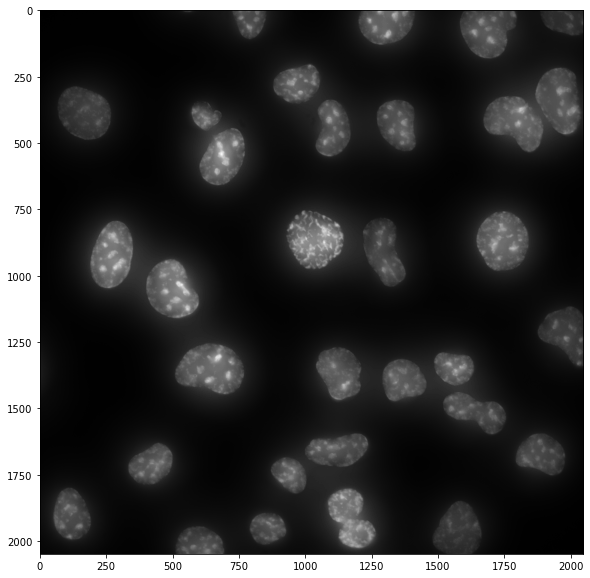

In [27]:
# Choose DAPI (only channel 1 belongs to test set of classifier )
channel = 1
id_ = [0,0]

# Get data
mypath = generatePaths(channel,id_)[0][0]
raw = plt.imread(mypath, cv.IMREAD_UNCHANGED)
raw = raw.astype(float)

# Display
plt.imshow(raw)
plt.show()

In [28]:
# Compute gradients in x and y directions using the Sobel mask
grad_x = cv.Sobel(raw,ddepth=-1,dx=1,dy=0,ksize=31)
grad_y = cv.Sobel(raw,ddepth=-1,dx=0,dy=1,ksize=31)
grad_mag = np.sqrt(np.power(grad_x,2) + np.power(grad_y,2))
grad_scaled = grad_mag/np.max(grad_mag)*np.max(raw)

# Store pictures
images = [grad_scaled, grad_scaled+raw, raw]

# Scale them for Stardist use
resized = [cv.resize(image, (256,256)) for image in images]

In [35]:
# Run Stardist
stack = []
for img in resized:
    labels, infos = model.predict_instances(normalize(img))
    stack.append(labels)
    points = infos['points']
    prob = infos['prob']
    
# Compute attention mask
attention_mask = np.sum(np.array(stack),axis = 0)
blobs = measure.label(attention_mask>1)
    
# Add border
add = 50

input_ = cv.copyMakeBorder(resized[2], add, add, add, add, cv.BORDER_CONSTANT, value=[0, 0, 0])
mask = cv.copyMakeBorder(blobs, add, add, add, add, cv.BORDER_CONSTANT, value=[0, 0, 0])
output = cv.copyMakeBorder(labels, add, add, add, add, cv.BORDER_CONSTANT, value=[0, 0, 0])
    
# define size of data
size = 64
e = int(size/2)
    
all_ = []
for x,y,p in zip(points[:,0], points[:,1], prob[:]):
        
    # Compensate border 
    x += add
    y += add
        
    # Extract area of interest
    nuc = input_[x-e:x+e,y-e:y+e]
    crop = mask[x-e:x+e,y-e:y+e]
    out = output[x-e:x+e,y-e:y+e]
        
    # Get value of label at the center
    nuc_mag = crop[32,32]
    out_mag = out[32,32]
        
    # Filter/dim input
    nuc = nuc*((crop == nuc_mag)+.25*(crop!=nuc_mag).astype(int))
    out = out*(out==out_mag)
    
    # Standardize
    nuc = (nuc-nuc.mean())/nuc.std()
    out = (out-out.mean())/out.std()
    
    # Merge and store
    tmp = np.array([nuc,out])
    all_.append(tmp)
    
# Create tensor and feed classifier
input_ = torch.from_numpy(np.array(all_)).float()
output = classifier(input_)
value,idx = output.max(1)

# Reject output with low confidence
for i in range(len(value)):
    if value[i].item() < 0.05: idx[i] = 3
    

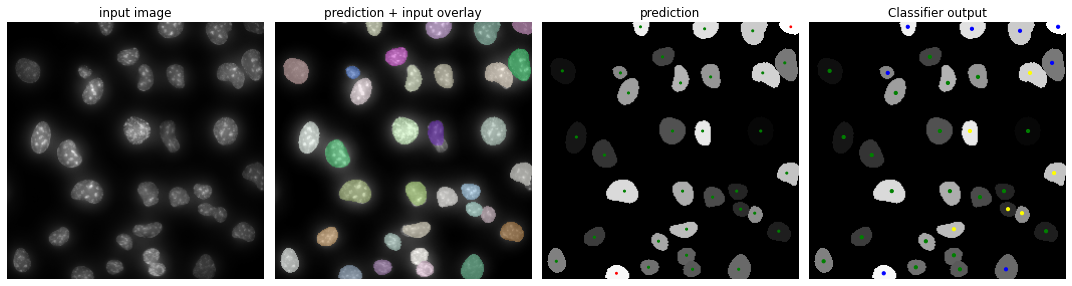

In [46]:
# Display result
plt.figure(figsize=(15,15))

plt.subplot(1,4,1)
plt.imshow(resized[2], cmap="gray")
plt.title("input image")
plt.axis('off')

plt.subplot(1,4,2)
plt.imshow(render_label(labels, img=resized[2]))
plt.title("prediction + input overlay")
plt.axis('off')

plt.subplot(1,4,3)
plt.imshow(labels,cmap='gray')
plt.scatter(points[:,1],points[:,0],s=prob*5,color= ['green' if pro>0.75 else 'red' for pro in prob])
plt.title("prediction")
plt.axis('off')

convert={0:'blue',1:'green',2:'yellow',3:'purple'}
plt.subplot(1,4,4)
plt.imshow(labels,cmap='gray')
plt.scatter(points[:,1],points[:,0],s=10,color= [convert[tag.item()] for tag in idx])
plt.title("Classifier output")
plt.axis('off')
    
plt.tight_layout()
plt.show()